# Part 8. Avoid horizontal edges

In the previous part, we've found that `tube` fuction may mistakingly put two or more nodes on the same layer even when they're connected (and should remain to different layers therefore). Here, we want to fix this defect.

In [1]:
# Rendering defaults
WIDTH = 5

In [3]:
import matplotlib.pyplot as plt
from enum import IntEnum
from dataclasses import dataclass, field, replace
from operator import itemgetter
from random import randint
from typing import Any, Dict, List, Set, Union, Optional

SiebenApp classes:

In [4]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For legacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


Drawing function

In [5]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        # print(goal_id, row, col)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    # print(xpos)
    # print(ypos)
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

A graph to render.

In [6]:
rr0 = RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='node 1', is_open=True, is_switchable=False, edges=[(2, EdgeType.PARENT), (3, EdgeType.PARENT), (4, EdgeType.PARENT), (5, EdgeType.PARENT), (40, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='node 2', is_open=True, is_switchable=True, edges=[(43, EdgeType.PARENT), (44, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='node 3', is_open=True, is_switchable=False, edges=[(6, EdgeType.BLOCKER), (7, EdgeType.BLOCKER), (8, EdgeType.BLOCKER), (30, EdgeType.PARENT), (37, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='node 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='node 5', is_open=True, is_switchable=False, edges=[(6, EdgeType.PARENT), (7, EdgeType.PARENT), (8, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=6, raw_id=6, name='node 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='node 7', is_open=True, is_switchable=False, edges=[(9, EdgeType.BLOCKER), (16, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=8, raw_id=8, name='node 8', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=9, raw_id=9, name='node 9', is_open=True, is_switchable=False, edges=[(10, EdgeType.PARENT), (11, EdgeType.PARENT), (12, EdgeType.PARENT), (13, EdgeType.PARENT), (14, EdgeType.PARENT), (15, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=10, raw_id=10, name='node 10', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=11, raw_id=11, name='node 11', is_open=False, is_switchable=True, edges=[(51, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=12, raw_id=12, name='node 12', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=13, raw_id=13, name='node 13', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=14, raw_id=14, name='node 14', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=15, raw_id=15, name='node 15', is_open=True, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=16, raw_id=16, name='node 16', is_open=False, is_switchable=True, edges=[(17, EdgeType.PARENT), (18, EdgeType.PARENT), (19, EdgeType.PARENT), (20, EdgeType.PARENT), (24, EdgeType.PARENT), (25, EdgeType.PARENT), (26, EdgeType.PARENT), (27, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=17, raw_id=17, name='node 17', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=18, raw_id=18, name='node 18', is_open=False, is_switchable=False, edges=[(23, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=19, raw_id=19, name='node 19', is_open=False, is_switchable=False, edges=[(21, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=20, raw_id=20, name='node 20', is_open=False, is_switchable=False, edges=[(21, EdgeType.PARENT), (22, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=21, raw_id=21, name='node 21', is_open=False, is_switchable=False, edges=[(38, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=22, raw_id=22, name='node 22', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=23, raw_id=23, name='node 23', is_open=False, is_switchable=False, edges=[(38, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=24, raw_id=24, name='node 24', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=25, raw_id=25, name='node 25', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=26, raw_id=26, name='node 26', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=27, raw_id=27, name='node 27', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=28, raw_id=28, name='node 28', is_open=False, is_switchable=True, edges=[(29, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=29, raw_id=29, name='node 29', is_open=False, is_switchable=False, edges=[(45, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=30, raw_id=30, name='node 30', is_open=True, is_switchable=True, edges=[(31, EdgeType.PARENT), (32, EdgeType.PARENT), (33, EdgeType.PARENT), (34, EdgeType.PARENT), (35, EdgeType.PARENT), (36, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=31, raw_id=31, name='node 31', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=32, raw_id=32, name='node 32', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=33, raw_id=33, name='node 33', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=34, raw_id=34, name='node 34', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=35, raw_id=35, name='node 35', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=36, raw_id=36, name='node 36', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=37, raw_id=37, name='node 37', is_open=True, is_switchable=False, edges=[(9, EdgeType.PARENT), (16, EdgeType.PARENT), (28, EdgeType.PARENT), (42, EdgeType.PARENT), (46, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=38, raw_id=38, name='node 38', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=39, raw_id=39, name='node 39', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=40, raw_id=40, name='node 40', is_open=True, is_switchable=False, edges=[(39, EdgeType.PARENT), (41, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=41, raw_id=41, name='node 41', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=42, raw_id=42, name='node 42', is_open=False, is_switchable=True, edges=[(43, EdgeType.BLOCKER), (44, EdgeType.BLOCKER), (49, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=43, raw_id=43, name='node 43', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=44, raw_id=44, name='node 44', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=45, raw_id=45, name='node 45', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=46, raw_id=46, name='node 46', is_open=False, is_switchable=True, edges=[(47, EdgeType.PARENT), (48, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=47, raw_id=47, name='node 47', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=48, raw_id=48, name='node 48', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=49, raw_id=49, name='node 49', is_open=False, is_switchable=False, edges=[(50, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=50, raw_id=50, name='node 50', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=51, raw_id=51, name='node 51', is_open=False, is_switchable=False, edges=[], attrs={})], select=(1, 1), roots={1}, node_opts={1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26:{}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}})

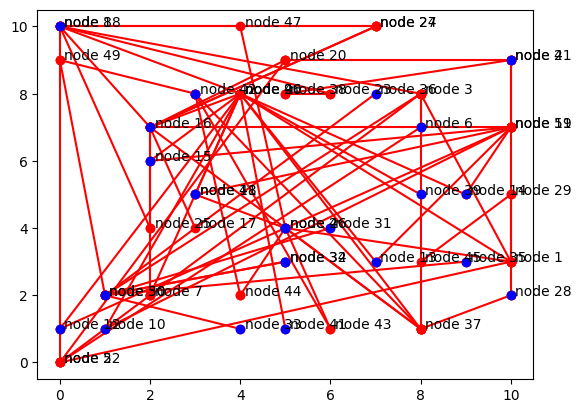

In [7]:
draw(rr0)

In [8]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

In order to reduce copy&paste between different steps, we'll introduce a new abstraction that holds all temporary values between steps.

In [9]:
@dataclass
class RenderStep:
    rr: RenderResult
    roots: List[int]
    layers: List[List[int]]

def pp(step: RenderStep):
    return [step.roots, step.layers]

Old layering functions, for comparision.

In [10]:
def tube0(step: RenderStep):
    new_layer: List[int] = step.roots[:WIDTH]
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    # Filter duplicates from new_roots
    new_layers = step.layers + [new_layer]
    already_added: Set[int] = {g for l in new_layers for g in l}
    filtered_roots: List[int] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(g)
            already_added.add(g)
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers)

In [13]:
step_0_1 = tube0(RenderStep(rr0, list(rr0.roots), []))
step_0_2 = tube0(step_0_1)
step_0_3 = tube0(step_0_2)
step_0_4 = tube0(step_0_3)
pp(step_0_4)

[[16, 31, 32, 33, 34, 35, 36, 28, 42, 46, 10, 11, 12, 13, 14, 15],
 [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8], [30, 37, 39, 41, 9]]]

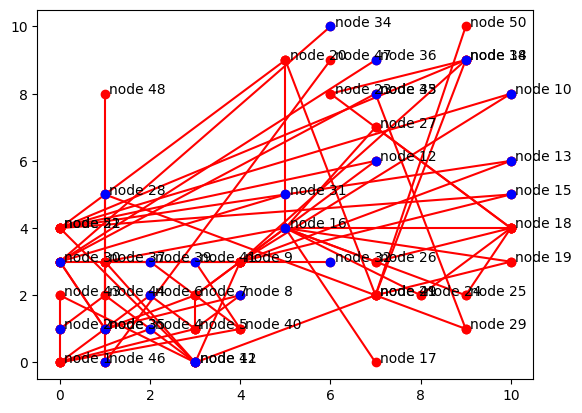

In [14]:
draw(step_0_4.rr)

In [20]:
step_0_4.rr.by_id(37).edges

[(9, <EdgeType.PARENT: 2>),
 (16, <EdgeType.PARENT: 2>),
 (28, <EdgeType.PARENT: 2>),
 (42, <EdgeType.PARENT: 2>),
 (46, <EdgeType.PARENT: 2>)]

What happened here: node 37 and node 9 are connected by an edge. Therefore, they shouldn't appear at the same layer. Nevertheless, the current version of algorithm doesn't take it into consideration. As a result, we obtain a horizontal line in the rendered graph. We should fix it.

## New function

Almost same `tube`, but that takes edges between new nodes into consideration.

In [23]:
def tube(step: RenderStep):
    # New logic: create new layer iteratively
    children_of_new_layer: Set[int] = set()
    new_layer: List[int] = []
    for goal_id in step.roots:
        if len(new_layer) >= WIDTH:
            break
        if goal_id not in children_of_new_layer:
            new_layer.append(goal_id)
            children_of_new_layer.update(e[0] for e in step.rr.by_id(goal_id).edges)
    # new_layer: List[int] = step.roots[:WIDTH]
    # End of new logic
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    # New logic: filter duplicates from new_roots
    new_layers = step.layers + [new_layer]
    already_added: Set[int] = {g for l in new_layers for g in l}
    filtered_roots: List[int] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(g)
            already_added.add(g)
    # End of new logic
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers)

In [24]:
step_1_1 = tube(RenderStep(rr0, list(rr0.roots), []))
step_1_2 = tube(step_1_1)
step_1_3 = tube(step_1_2)
step_1_4 = tube(step_1_3)
pp(step_1_4)

[[9, 16, 31, 32, 33, 34, 35, 36, 28, 42, 46],
 [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8], [30, 37, 39, 41]]]

Node 9 was not added!

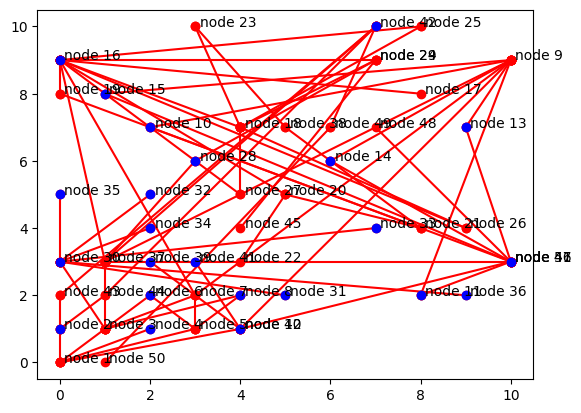

In [25]:
draw(step_1_4.rr)

### Compare next steps

In [27]:
step_0_5 = tube0(step_0_4)
step_1_5 = tube(step_1_4)
pp(step_0_5), pp(step_1_5)

([[35, 36, 28, 42, 46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34]]],
 [[34,
   35,
   36,
   28,
   42,
   46,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33]]])

In [28]:
step_0_6 = tube0(step_0_5)
step_1_6 = tube(step_1_5)
pp(step_0_6), pp(step_1_6)

([[10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49, 47, 48],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46]]],
 [[46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42]]])

In [29]:
step_0_7 = tube0(step_0_6)
step_1_7 = tube(step_1_6)
pp(step_0_7), pp(step_1_7)

([[15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49, 47, 48, 51],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14]]],
 [[14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49, 47, 48, 51],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13]]])

In [30]:
step_0_8 = tube0(step_0_7)
step_1_8 = tube(step_1_7)
pp(step_0_8), pp(step_1_8)

([[24, 25, 26, 27, 29, 49, 47, 48, 51, 23, 21, 22],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20]]],
 [[20, 24, 25, 26, 27, 29, 49, 47, 48, 51, 23, 21],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19]]])

In [31]:
step_0_9 = tube0(step_0_8)
step_1_9 = tube(step_1_8)
pp(step_0_9), pp(step_1_9)

([[49, 47, 48, 51, 23, 21, 22, 45],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20],
   [24, 25, 26, 27, 29]]],
 [[29, 49, 47, 48, 51, 23, 21, 22],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19],
   [20, 24, 25, 26, 27]]])

In [32]:
step_0_10 = tube0(step_0_9)
step_1_10 = tube(step_1_9)
pp(step_0_10), pp(step_1_10)

([[21, 22, 45, 50, 38],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20],
   [24, 25, 26, 27, 29],
   [49, 47, 48, 51, 23]]],
 [[23, 21, 22, 45, 50],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19],
   [20, 24, 25, 26, 27],
   [29, 49, 47, 48, 51]]])

Almost no difference ampng the way. The delta of 1 node continues to persist.

In [33]:
step_0_11 = tube0(step_0_10)
step_1_11 = tube(step_1_10)
pp(step_0_11), pp(step_1_11)

([[],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41, 9],
   [16, 31, 32, 33, 34],
   [35, 36, 28, 42, 46],
   [10, 11, 12, 13, 14],
   [15, 17, 18, 19, 20],
   [24, 25, 26, 27, 29],
   [49, 47, 48, 51, 23],
   [21, 22, 45, 50, 38]]],
 [[38],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19],
   [20, 24, 25, 26, 27],
   [29, 49, 47, 48, 51],
   [23, 21, 22, 45, 50]]])

Finished for the old greedy algorithm, but not for the new.

In [34]:
step_1_12 = tube(step_1_11)
pp(step_1_12)

[[],
 [[1],
  [2, 3, 4, 5, 40],
  [43, 44, 6, 7, 8],
  [30, 37, 39, 41],
  [9, 16, 31, 32, 33],
  [34, 35, 36, 28, 42],
  [46, 10, 11, 12, 13],
  [14, 15, 17, 18, 19],
  [20, 24, 25, 26, 27],
  [29, 49, 47, 48, 51],
  [23, 21, 22, 45, 50],
  [38]]]

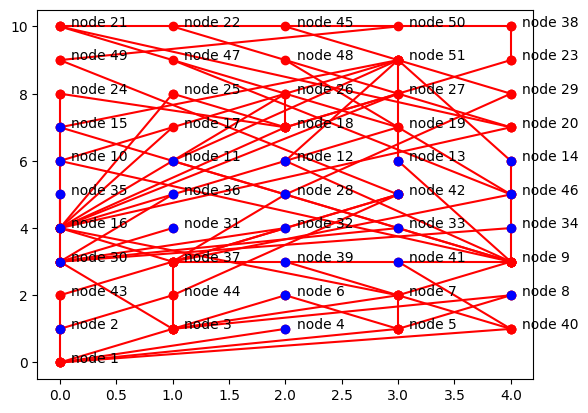

In [36]:
draw(step_0_11.rr)

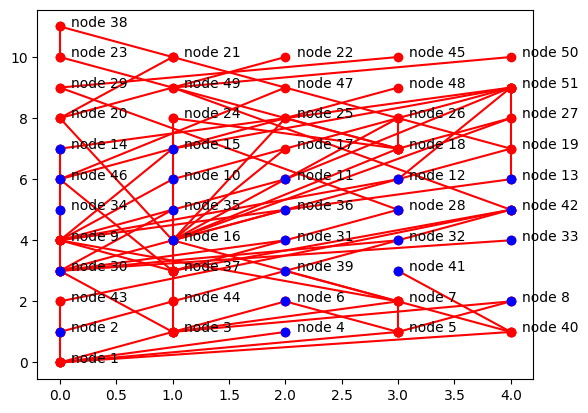

In [37]:
draw(step_1_12.rr)

No more horizontal lines, fine! And all other layers are still filled with the maximal possible density.

## Horizontal adjustment, again

Now, let's take a look on the graph after the horizontal adjustment introduced in the part 3.

In [44]:
def avg(vals):
    return sum(vals) / len(vals)

def shift_neutral(ds):
    return avg([d[1] for d in ds])

def calc_shift(rr: RenderResult, shift_fn):
    connected: Dict[int, Set[int]] = {row.goal_id: set() for row in rr.rows}
    for row in rr.rows:
        for e in row.edges:
            connected[e[0]].add(row.goal_id)
            connected[row.goal_id].add(e[0])

    result = {}
    for row in rr.rows:
        goal_id = row.goal_id
        opts = rr.node_opts[goal_id]
        row_, col_ = opts['row'], opts['col']
        deltas = [
            (rr.node_opts[c]['row'] - row_,
             rr.node_opts[c]['col'] - col_)
            for c in connected[goal_id]
        ]
        result[goal_id] = shift_fn(deltas)
    return result

def adjust_horisontal(rr: RenderResult, mult):
    deltas = calc_shift(rr, shift_neutral)
    new_opts = {
        goal_id: opts | {"col": opts["col"] + (mult * deltas[goal_id])}
        for goal_id, opts in rr.node_opts.items()
    }
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

def normalize_cols(rr: RenderResult) -> RenderResult:
    order0 = {}
    for goal_id, opts in rr.node_opts.items():
        row, col = opts["row"], opts["col"]
        if row not in order0:
            order0[row] = []
        order0[row].append((col, goal_id))
    # print("order0: ", order0)
    order1 = {}
    for layer, tuples in order0.items():
        non_empty = list(round(t[0]) for t in tuples)
        need_drop = len(tuples) - len(set(non_empty))
        empty = {x for x in range(WIDTH)}.difference(non_empty)
        for i in range(need_drop):
            empty.pop()
        # print(f"{layer}: non-empty {non_empty}, empty {empty}, dropped {need_drop}")
        order1[layer] = tuples + [(e, -10) for e in empty]
    # print("order1: ", order1)
    order2 = {k: sorted(v) for k, v in order1.items()}
    # print("order2: ", order2)
    indexed0 = {k: [t[1] for t in v] for k, v in order2.items()}
    # print("indexed0: ", indexed0)
    indexed1 = {}
    for layer in indexed0.values():
        for i, goal_id in enumerate(layer):
            if goal_id > 0:
                indexed1[goal_id] = i
    # print("indexed1: ", indexed1)
    new_opts = {
        goal_id: opts | {"col": indexed1[goal_id]}
        for goal_id, opts in rr.node_opts.items()
    }
    # print(new_opts)
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

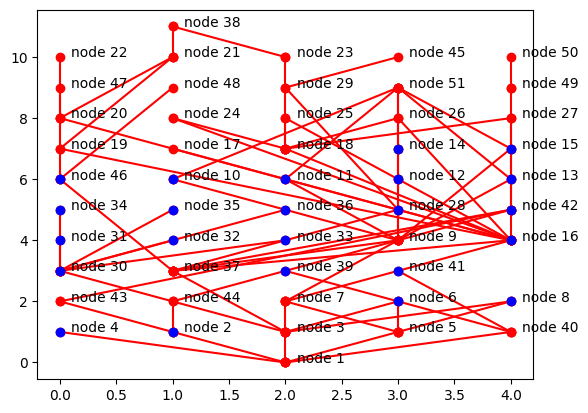

In [45]:
rr_12_1 = adjust_horisontal(step_1_12.rr, 1.0)
rr_12_2 = adjust_horisontal(rr_12_1, 0.5)
rr_12_3 = normalize_cols(rr_12_2)
draw(rr_12_3)

Looks pretty good.

## Next questions

There are still several questions about the algorithm. What's coming into head right now:

1. **Performance**: there's still a room for improvement. It's not cool to have things like `new_opts = {... for goal_id, opts in step.rr.node_opts.items()`. We visit literally all nodes in `rr` while update only some of them. This place (and, probably, several others) should be reviewed and rewritten.
2. **Wrong ordered edges?** I suspect that, in theory, we still could place nodes in wrong order. A node may have different paths from root to it, one short and another, long. Here, we place nodes by their shortest paths. Therefore, the longer path could have a downgoing edge (from higher layer to lower). It's not OK.
3. **Multiple roots**. We need to re-check algorithm for graph containing multiple root nodes. We could have either several not-connected sub-graphs (a result of filtering, for example), or sub-graphs that have some intermediate connections between them. Probably, an energy-based logic would be more useful here.

Performance optimizations would go at the end, and the next step should be an order check.

In [52]:
for r in rr_12_3.rows:
    my_row = rr_12_3.node_opts[r.goal_id]["row"]
    child_rows = [(e, rr_12_3.node_opts[e[0]]["row"]) for e in r.edges]
    wrong_child_rows = [(e[0], row) for e, row in child_rows if row < my_row]
    if wrong_child_rows:
        print(f"goal {r.goal_id}: row {my_row}, children {wrong_child_rows}")

goal 24: row 8, children [(18, 7)]
goal 25: row 8, children [(18, 7)]
goal 26: row 8, children [(18, 7)]
goal 27: row 8, children [(18, 7)]
goal 42: row 5, children [(43, 2), (44, 2)]
